In [25]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-s2zrci9m
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-s2zrci9m
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [26]:
!pip install opendatasets

In [27]:
!pip install tensorflow==2.10

In [28]:
import numpy as np
import pandas as pd

import os
import pathlib
import glob
import opendatasets as od

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import ZeroPadding2D
import keras
from keras.utils import img_to_array, load_img

import segmentation_models as sm
sm.set_framework('keras')

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [29]:
od.download('https://www.kaggle.com/datasets/humansintheloop/plant-semantic-segmentation')

Skipping, found downloaded files in "./plant-semantic-segmentation" (use force=True to force download)


In [30]:
caminho_raiz = '/content/plant-semantic-segmentation/Plant segmentation'
data_dir = pathlib.Path(caminho_raiz)
subpastas = data_dir.glob('**/*')
subpastas = [x for x in subpastas if x.is_dir()]

In [31]:
print(f"Subpastas: {subpastas}")

Subpastas: [PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images')]


In [32]:
cam_images = list(subpastas[1].iterdir())
cam_masks = list(subpastas[0].iterdir())

In [33]:
cam_images = sorted(cam_images)
cam_masks = sorted(cam_masks)

In [34]:
print(f"Imagem original: {cam_images[10:13]}")
print(f"Máscara imagem: {cam_masks[10:13]}")

Imagem original: [PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images/T02_Box007_2017-09-13T06-44-53-948.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images/T02_Box007_2017-09-14T08-17-35-120.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images/T02_Box007_2017-09-18T08-52-54-989.png')]
Máscara imagem: [PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks/T02_Box007_2017-09-13T06-44-53-948.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks/T02_Box007_2017-09-14T08-17-35-120.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks/T02_Box007_2017-09-18T08-52-54-989.png')]


In [35]:
print(f"Total de imagens de treino: {len(cam_images)} | Toral de máscaras de treino: {len(cam_masks)}")

Total de imagens de treino: 144 | Toral de máscaras de treino: 144


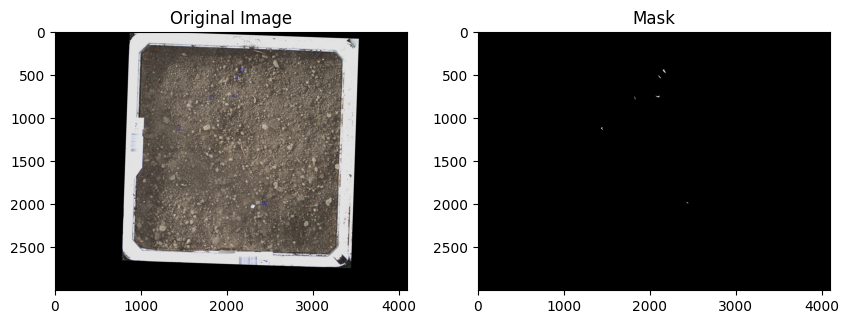

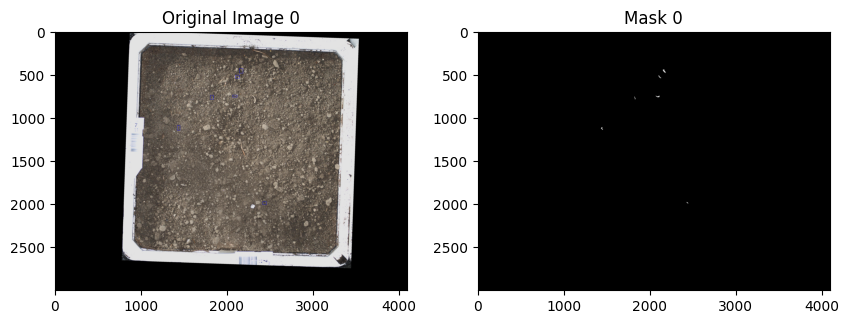

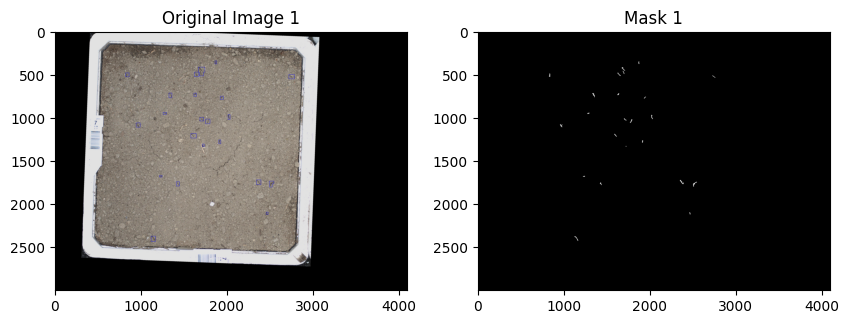

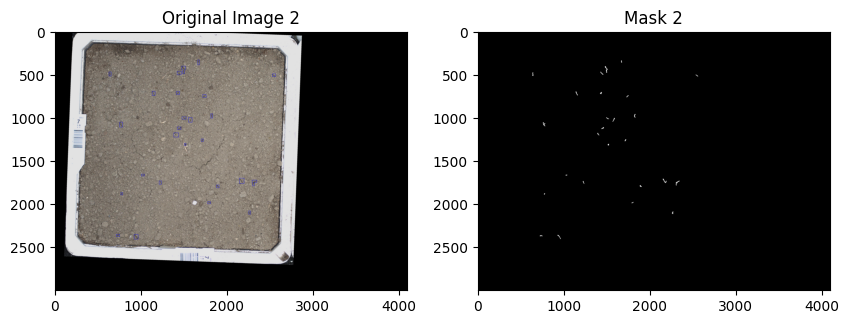

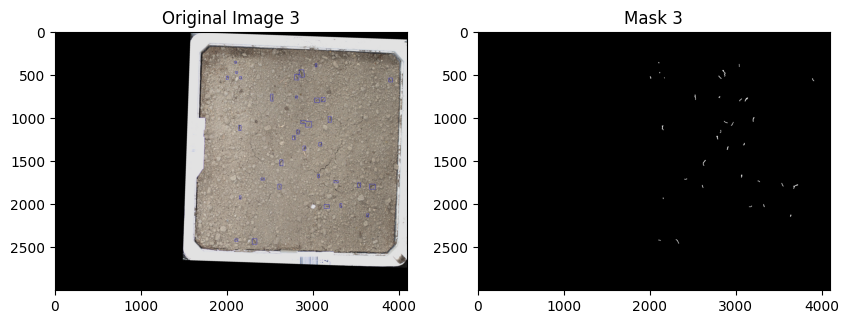

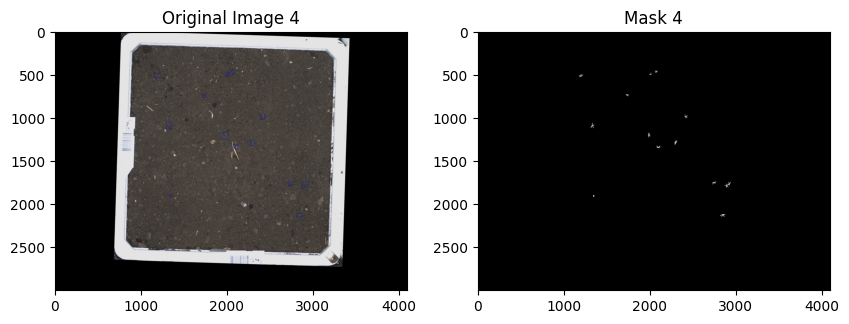

In [36]:
image_index = 0

img = cv2.imread(str(cam_images[image_index]))
mask = cv2.imread(str(cam_masks[image_index]), cv2.IMREAD_GRAYSCALE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Mask")

plt.show()

num_images_to_display = 5

for i in range(num_images_to_display):
  img = cv2.imread(str(cam_images[i]))
  mask = cv2.imread(str(cam_masks[i]), cv2.IMREAD_GRAYSCALE)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img_rgb)
  axes[0].set_title(f"Original Image {i}")

  axes[1].imshow(mask, cmap='gray')
  axes[1].set_title(f"Mask {i}")

  plt.show()

In [37]:
height = 256
width = 256
channels = 3

In [38]:
imagens = []
mascaras = []

count_img = 0
count_mask = 0

img_size = (height, width)

for caminho in cam_images:
  img = cv2.imread(str(caminho))
  img = cv2.resize(img, img_size)
  count_img += 1
  imagens.append(img)

for caminho in cam_masks:
  mask = cv2.imread(str(caminho), cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, img_size)
  count_mask += 1
  mascaras.append(mask)

X = np.array(imagens)
y = np.array(mascaras)
print(f'Imagens_train: {count_img} | Mascaras_train: {count_mask}')

Imagens_train: 144 | Mascaras_train: 144


In [39]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
Y_train.shape

(115, 256, 256)

In [41]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [42]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

Y_train = Y_train / 255.0
Y_val = Y_val / 255.0

In [43]:
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [44]:
hist = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=5
)

Epoch 1/5
4/4 [==============================] - 212s 50s/step - loss: 1.5007 - iou_score: 0.0232 - val_loss: 1.2459 - val_iou_score: 3.6999e-04
Epoch 2/5
4/4 [==============================] - 203s 50s/step - loss: 1.3328 - iou_score: 0.0286 - val_loss: 1.2560 - val_iou_score: 3.5383e-04
Epoch 3/5
4/4 [==============================] - 207s 52s/step - loss: 1.2365 - iou_score: 0.0347 - val_loss: 1.2723 - val_iou_score: 4.0779e-04
Epoch 4/5
4/4 [==============================] - 205s 50s/step - loss: 1.1731 - iou_score: 0.0424 - val_loss: 1.2416 - val_iou_score: 0.0021
Epoch 5/5
4/4 [==============================] - 199s 49s/step - loss: 1.1267 - iou_score: 0.0519 - val_loss: 1.2353 - val_iou_score: 0.0016
